# Create spherical harmonic coefficients from an ocean mask
*Author: R. Rietbroek Oct 2024 (r.rietbroek@utwente.nl)*

The ocean function is defined to be one over the ocean and 0 over land areas. This mask function can also be converted to a set of spherical hamronic coefficients. These may for example be used in applying the Sea level equation in the spherical harmonic domain.

## 1. Obtain a (fine ocean grid)
As a starting point we can take a masked grid which was generated using using [an example recipe from geoslurp](https://github.com/strawpants/geoslurp/blob/master/docs/source/notebooks/OceanFunction.ipynb). 

In [18]:
import requests
import os
import xarray as xr
import shxarray
import matplotlib.pyplot as mpl

In [2]:
url="https://github.com/strawpants/geoshapes/raw/refs/heads/master/raster/ocean/ne_10m_oceangrid_0.125.nc"
#temporary storage
outfile="/tmp/"+os.path.basename(url)
if not os.path.exists(outfile):
    r = requests.get(url)
    print(f"Downloading ocean grid {outfile}")
    with open(outfile,'wb') as fid:
        fid.write(r.content)
else:
    print(f"{outfile}, already downloaded")


dsoce=xr.open_dataset(outfile).fillna(0.0)
display(dsoce)

/tmp/ne_10m_oceangrid_0.125.nc, already downloaded


<xarray.Dataset> Size: 32MB
Dimensions:      (latitude: 1403, longitude: 2882)
Coordinates:
    band         int64 8B ...
  * longitude    (longitude) float64 23kB -180.0 -179.9 -179.8 ... 180.0 180.1
  * latitude     (latitude) float64 11kB 90.0 89.88 89.75 ... -85.12 -85.25
Data variables:
    spatial_ref  float64 8B 0.0
    oceanfunc    (latitude, longitude) float64 32MB 1.0 1.0 1.0 ... 0.0 0.0 0.0

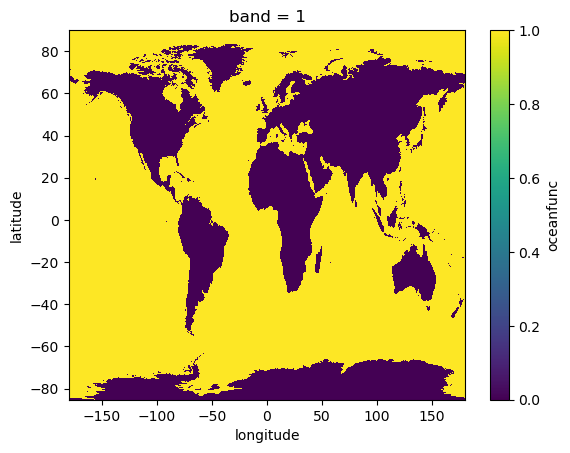

In [3]:
dsoce.oceanfunc.plot()

## 2. Convert the ocean grid to spherical harmonic coefficients

In [8]:
nmax=300 # note: a large nmax can take quite a while
# default uses a naive integration approach
dsocesh=dsoce.oceanfunc.sh.analysis(nmax)
display(dsocesh)
print(f"C00 coefficient (72% of Earth surface is ocean) {dsocesh.sel(n=0).data[0]}")

<xarray.DataArray (nm: 90601)> Size: 725kB
array([ 7.20970399e-01, -5.92399201e-02, -1.18297393e-01, ...,
        1.73853587e-04, -1.16902999e-04,  4.39577073e-05])
Coordinates:
  * nm       (nm) object 725kB MultiIndex
  * n        (nm) int64 725kB 0 1 1 1 2 2 2 2 ... 300 300 300 300 300 300 300
  * m        (nm) int64 725kB 0 -1 0 1 -2 -1 0 1 ... 294 295 296 297 298 299 300

C00 coefficient (72% of Earth surface is ocean) 0.7209703992440711


## 3. Convert the resulting spherical harmonic coefficients back to a grid and visualize the result

In [13]:
dsoce_back=dsocesh.sh.synthesis(lon=dsoce.longitude,lat=dsoce.latitude)

Text(0.5, 1.0, 'Ocean function after grid -> sh -> grid, nmax=300, (min,max)=(-0.36,1.30)')

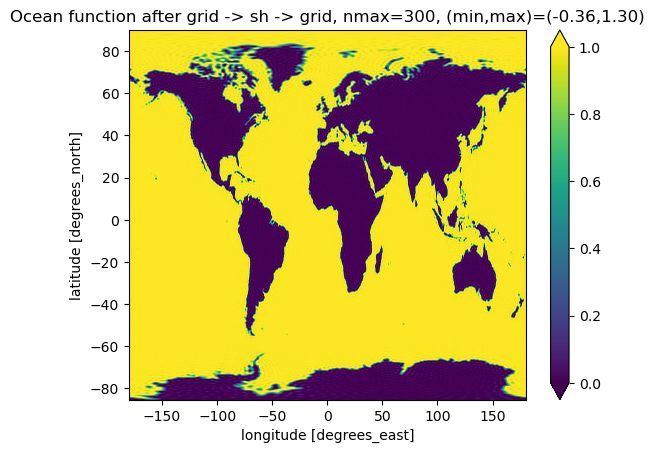

In [34]:
dsoce_back.plot(vmin=0,vmax=1)
ca=mpl.gca()
ca.set_title(f"Ocean function after grid -> sh -> grid, nmax={nmax}, (min,max)=({dsoce_back.min().data.item():.2f},{dsoce_back.max().data.item():.2f})")

Note that differences up to 0.3 are visible due to Gibb's phenomena

## 4. Write the results together with the input grid to the original netcdf file

In [53]:
outfilesh=f"/tmp/ne_10m_oceansh_n{nmax}.nc"
dsocesh.name="oceansh"
dsocesh.reset_index("nm").to_netcdf(outfilesh)